In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC



In [19]:

companies_fin=["BAC","BACHF","BBAS3.SA","BCS","BNP.PA","BRK-B","C","FMCC",
                "FNMA","GLE.PA","GS","HSBC","JPM","LYG","NAB.AX","UBS","WFC"]

companies=companies_fin

dfs = {}
for company in companies:
    
    path=f'Prediction Bankruptcy Data/{company}_'

    df1=pd.read_csv(path+'annual_financials.csv')
    df2=pd.read_csv(path+'annual_balance-sheet.csv')
    df3=pd.read_csv(path+'annual_cash-flow.csv')
    
    for column in df1.columns[2:]:
        column1 = pd.to_datetime(column).date()
        new_column_name = column1.replace(month=12,day=31).strftime("%Y-%m-%d")
        df1 = df1.rename(columns={column: new_column_name})
    
    
    for columnn in df2.columns[1:]:
        column2 = pd.to_datetime(columnn).date()
        new_column_name = column2.replace(month=12,day=31).strftime("%Y-%m-%d")
        df2 = df2.rename(columns={columnn: new_column_name})
        
    for columnnn in df3.columns[2:]:
        column3 = pd.to_datetime(columnnn).date()
        new_column_name = column3.replace(month=12,day=31).strftime("%Y-%m-%d")
        df3 = df3.rename(columns={columnnn: new_column_name})
        
    # Drop duplicate columns
    df1 = df1.loc[:, ~df1.columns.duplicated()]
    df2 = df2.loc[:, ~df2.columns.duplicated()]
    df3 = df3.loc[:, ~df3.columns.duplicated()]

       
    df=pd.concat([df1,df2,df3],ignore_index=True)
    
    df.insert(0,"Company Name",company)
    
    if company in companies:
        df.insert(0,"Sector","Tech")
    elif company in companies_pharma:
        df.insert(0,"Sector","Pharma")
    elif company in companies_fin:
        df.insert(0,"Sector","fin")
    else:
        pass
    
    dfs[company] = df   
 
    
df = pd.concat(dfs.values())

df.drop(['ttm'], axis=1, inplace=True)

df

,Sector,Company Name,name,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,2014-12-31,2013-12-31,...,1994-12-31,1993-12-31,1992-12-31,1991-12-31,1990-12-31,1989-12-31,1988-12-31,1987-12-31,1986-12-31,1985-12-31
0,Tech,BAC,TotalRevenue,"91,244,000,000","91,247,000,000","87,352,000,000","83,701,000,000","82,246,000,000","83,117,000,000","86,041,000,000",...,"7,807,000,000","6,822,000,000","6,260,000,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tech,BAC,InterestExpense,"22,345,000,000","19,337,000,000","12,912,000,000","9,961,000,000","10,549,000,000","10,934,000,000","12,755,000,000",...,"5,318,000,000","3,570,000,000","3,682,000,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tech,BAC,PretaxIncome,"32,754,000,000","34,584,000,000","29,213,000,000","25,153,000,000","22,154,000,000","6,855,000,000","16,172,000,000",...,"2,555,000,000","1,991,000,000","1,396,000,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tech,BAC,TaxProvision,"5,324,000,000","6,437,000,000","10,981,000,000","7,247,000,000","6,266,000,000","2,022,000,000","4,741,000,000",...,"865,000,000","690,000,000","251,000,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tech,BAC,NetIncomeContinuousOperations,"27,430,000,000","28,147,000,000","18,232,000,000","17,906,000,000","15,888,000,000","4,833,000,000","11,431,000,000",...,"1,690,000,000","1,301,000,000","1,145,000,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Tech,WFC,EndCashPosition,"141,250,000,000","173,287,000,000","23,367,000,000","20,729,000,000","19,111,000,000","19,571,000,000","19,919,000,000",...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
111,Tech,WFC,FreeCashFlow,"6,730,000,000","36,073,000,000","18,722,000,000","169,000,000","14,772,000,000","17,529,000,000","57,641,000,000",...,"2,641,800,000","178,100,000","1,967,400,000","-323,000,000","-369,100,000","-407,200,000",NaN,NaN,NaN,NaN
112,Tech,WFC,\tOperatingCashFlow,"6,730,000,000","36,073,000,000","18,722,000,000","169,000,000","14,772,000,000","17,529,000,000","57,641,000,000",...,"2,907,800,000","389,400,000","2,141,800,000","-244,900,000","-277,100,000","-322,100,000",NaN,NaN,NaN,NaN
113,Tech,WFC,\tCapitalExpenditure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"-266,000,000","-211,300,000","-174,400,000","-78,100,000","-92,000,000","-85,100,000",NaN,NaN,NaN,NaN


In [20]:
df['name']=df['name'].str.replace('\t','')

df = df[df['Company Name'].isin(companies)]
columns=df.columns[3:]

for column in columns:
    df[column] = df[column].str.replace(',','').astype(float)
    
pd.set_option('display.float_format', '{:.2f}'.format)

#df = df.drop_duplicates('name').reset_index(drop = True)
df=df.drop(['Sector'],axis=1)
df = df.drop_duplicates(subset=['name', 'Company Name'])
#df.set_index('name', inplace = True)
df.rename(columns={col: pd.to_datetime(col).year for col in df.columns[2:]}, inplace=True)
#df.drop(2020, axis=1, inplace=True)
df = df.drop_duplicates()

df

,Company Name,name,2019,2018,2017,2016,2015,2014,2013,2012,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,BAC,TotalRevenue,91244000000.00,91247000000.00,87352000000.00,83701000000.00,82246000000.00,83117000000.00,86041000000.00,81264000000.00,...,7807000000.00,6822000000.00,6260000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAC,InterestExpense,22345000000.00,19337000000.00,12912000000.00,9961000000.00,10549000000.00,10934000000.00,12755000000.00,16744000000.00,...,5318000000.00,3570000000.00,3682000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAC,PretaxIncome,32754000000.00,34584000000.00,29213000000.00,25153000000.00,22154000000.00,6855000000.00,16172000000.00,3072000000.00,...,2555000000.00,1991000000.00,1396000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAC,TaxProvision,5324000000.00,6437000000.00,10981000000.00,7247000000.00,6266000000.00,2022000000.00,4741000000.00,-1116000000.00,...,865000000.00,690000000.00,251000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAC,NetIncomeContinuousOperations,27430000000.00,28147000000.00,18232000000.00,17906000000.00,15888000000.00,4833000000.00,11431000000.00,4188000000.00,...,1690000000.00,1301000000.00,1145000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,WFC,CashDividendsPaid,-9589000000.00,-9314000000.00,-9109000000.00,-9038000000.00,-8826000000.00,-8143000000.00,-6970000000.00,-5457000000.00,...,-268000000.00,-212800000.00,-179000000.00,-129800000.00,-86300000.00,-74200000.00,NaN,NaN,NaN,NaN
106,WFC,NetOtherFinancingCharges,-1091000000.00,-1041000000.00,-496000000.00,-12000000.00,254000000.00,-48000000.00,111000000.00,-385000000.00,...,3000000.00,3200000.00,3000000.00,-26900000.00,9500000.00,-40100000.00,NaN,NaN,NaN,NaN
108,WFC,ChangeInCashSupplementalAsReported,-32037000000.00,-42660000000.00,2638000000.00,1618000000.00,-460000000.00,-348000000.00,-1941000000.00,2420000000.00,...,416300000.00,66100000.00,-253100000.00,-1758800000.00,982400000.00,-353100000.00,NaN,NaN,NaN,NaN
109,WFC,BeginningCashPosition,173287000000.00,215947000000.00,20729000000.00,19111000000.00,19571000000.00,19919000000.00,21860000000.00,19440000000.00,...,3608000000.00,2993100000.00,3035200000.00,4556300000.00,1721200000.00,1876200000.00,NaN,NaN,NaN,NaN


In [21]:
dfs = []

for company in companies:
    start_year = 1985
    end_year = 2020

    ticker = yf.Ticker(company)

    for year in range(start_year, end_year + 1):
        start_date = datetime.date(year, 1, 1)
        end_date = datetime.date(year, 12, 31)

        # Get historical stock price data for the year
        historical_data = ticker.history(period="1d", start=start_date, end=end_date)
        if not historical_data.empty:
        # Extract the 'Close' column (closing stock prices) from the historical data
              closing_prices = historical_data['Close']

        # Get the number of shares outstanding from the company's info
              shares_outstanding = ticker.info['sharesOutstanding']

        # Calculate historical market capitalization by multiplying closing prices by shares outstanding
              historical_market_cap = closing_prices * shares_outstanding

        # Get the last date of the year
              last_date = historical_market_cap.index[-1]

        # Get the market capitalization value for the last date
              market_cap_value = historical_market_cap[last_date]
        else:
              market_cap_value=np.nan
                
        # Create a DataFrame for the current year and company
        df_mc = pd.DataFrame({
                 "Company Name": [company],
                 "Year": [year],
                 "name": [market_cap_value]
        })

        dfs.append(df_mc)
        
market_cap_df = pd.concat(dfs, ignore_index=True)

market_cap_df

BACHF: Data doesn't exist for startDate = 473403600, endDate = 504853200
BACHF: Data doesn't exist for startDate = 504939600, endDate = 536389200
BACHF: Data doesn't exist for startDate = 536475600, endDate = 567925200
BACHF: Data doesn't exist for startDate = 568011600, endDate = 599547600
BACHF: Data doesn't exist for startDate = 599634000, endDate = 631083600
BACHF: Data doesn't exist for startDate = 631170000, endDate = 662619600
BACHF: Data doesn't exist for startDate = 662706000, endDate = 694155600
BACHF: Data doesn't exist for startDate = 694242000, endDate = 725778000
BACHF: Data doesn't exist for startDate = 725864400, endDate = 757314000
BACHF: Data doesn't exist for startDate = 757400400, endDate = 788850000
BACHF: Data doesn't exist for startDate = 788936400, endDate = 820386000
BACHF: Data doesn't exist for startDate = 820472400, endDate = 852008400
BACHF: Data doesn't exist for startDate = 852094800, endDate = 883544400
BACHF: Data doesn't exist for startDate = 883630800

LYG: Data doesn't exist for startDate = 757400400, endDate = 788850000
LYG: Data doesn't exist for startDate = 788936400, endDate = 820386000
LYG: Data doesn't exist for startDate = 820472400, endDate = 852008400
LYG: Data doesn't exist for startDate = 852094800, endDate = 883544400
LYG: Data doesn't exist for startDate = 883630800, endDate = 915080400
LYG: Data doesn't exist for startDate = 915166800, endDate = 946616400
LYG: Data doesn't exist for startDate = 946702800, endDate = 978238800
NAB.AX: Data doesn't exist for startDate = 473346000, endDate = 504795600
NAB.AX: Data doesn't exist for startDate = 504882000, endDate = 536331600
NAB.AX: Data doesn't exist for startDate = 536418000, endDate = 567867600
UBS: Data doesn't exist for startDate = 473403600, endDate = 504853200
UBS: Data doesn't exist for startDate = 504939600, endDate = 536389200
UBS: Data doesn't exist for startDate = 536475600, endDate = 567925200
UBS: Data doesn't exist for startDate = 568011600, endDate = 5995476

,Company Name,Year,name
0,BAC,1985,15108746214.23
1,BAC,1986,15913432213.01
2,BAC,1987,12706900150.80
3,BAC,1988,20585315939.05
4,BAC,1989,35844593188.04
...,...,...,...
607,WFC,2016,165094900865.88
608,WFC,2017,186904786827.89
609,WFC,2018,145153786607.88
610,WFC,2019,176771972781.42


In [22]:
market_cap_df_pivot = market_cap_df.pivot(index='Company Name', columns='Year', values='name')

market_cap_df_pivot.reset_index(drop=False, inplace=True)

market_cap_df_pivot.insert(1, "name", "MarketCap")
market_cap_df_pivot.columns.name = None

market_cap_df_pivot

,Company Name,name,1985,1986,1987,1988,1989,1990,1991,1992,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,BAC,MarketCap,15108746214.23,15913432213.01,12706900150.80,20585315939.05,35844593188.04,18820499419.61,34166798851.53,45193238234.80,...,36416325869.61,74765380683.27,102582465579.80,120549015672.23,114752959717.98,151069451690.06,204978879825.59,172471203681.69,254214249908.41,222638326582.91
1,BACHF,MarketCap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16042386336.11,20498600678.47,20052978870.41,26201369077.73,21437481525.29,21967514562.30,26888020569.58,23875196872.85,24794407269.14,22090563909.23
2,BBAS3.SA,MarketCap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31249480687.42,36154864067.57,38106795177.69,39700357237.94,27198016478.58,54235846398.11,63373774090.17,96586534862.39,116907078132.38,89337582769.14
3,BCS,MarketCap,NaN,4662665202.14,5500027911.04,4901217940.68,6573225926.09,7483906748.97,7586823267.76,7099928025.96,...,27025376847.17,42293066579.51,50349252281.75,43225548856.20,38564930825.40,33310062576.06,33465710490.87,23677861322.99,30916601671.70,27368731999.90
4,BNP.PA,MarketCap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18346716439.83,26816430965.99,36963491650.59,32902402454.75,36386646540.56,43973071346.53,47125347318.84,31469098324.06,45226847231.16,41698576512.14
5,BRK-B,MarketCap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99805746212.71,115829603908.71,154404585886.21,198944363943.14,174313403146.72,213189245619.00,259285640168.29,264334791228.43,295309879626.72,300398271190.57
6,C,MarketCap,21106606134.45,29761200619.77,17952712887.14,16734328656.28,22185509380.97,17768982674.81,31471464401.39,39788242141.12,...,40380725121.64,59948429878.82,79855548464.23,84414743019.06,80740533023.78,92596851099.97,117622694386.44,83744734909.26,132121350101.04,105211650188.61
7,FMCC,MarketCap,NaN,NaN,NaN,1870909672.50,2543517434.36,1895517636.43,5192827028.10,5986023809.89,...,136512602.46,175516215.61,1904675937.16,1352124816.96,1053097254.94,2431224525.88,1638151268.24,695564268.34,1878673560.67,1501638636.72
8,FNMA,MarketCap,1577177314.60,2433934604.31,1873633765.26,3146858790.35,6400456801.85,6758567272.58,13630170734.80,15457394936.56,...,231618000.25,301103384.80,3497431729.59,2420407967.16,1899267557.19,4516551048.04,3068938568.04,1250737232.42,3485850840.80,2733092240.75
9,GLE.PA,MarketCap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6969975645.19,11403941320.44,17299462630.39,14645527259.41,18496636439.52,21374544285.41,20610038960.65,14098401233.19,17250689797.62,11469157686.65


In [23]:
merged_df = pd.concat([df, market_cap_df_pivot], ignore_index=True)
merged_df

,Company Name,name,2019,2018,2017,2016,2015,2014,2013,2012,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,2020
0,BAC,TotalRevenue,91244000000.00,91247000000.00,87352000000.00,83701000000.00,82246000000.00,83117000000.00,86041000000.00,81264000000.00,...,6822000000.00,6260000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAC,InterestExpense,22345000000.00,19337000000.00,12912000000.00,9961000000.00,10549000000.00,10934000000.00,12755000000.00,16744000000.00,...,3570000000.00,3682000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAC,PretaxIncome,32754000000.00,34584000000.00,29213000000.00,25153000000.00,22154000000.00,6855000000.00,16172000000.00,3072000000.00,...,1991000000.00,1396000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAC,TaxProvision,5324000000.00,6437000000.00,10981000000.00,7247000000.00,6266000000.00,2022000000.00,4741000000.00,-1116000000.00,...,690000000.00,251000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAC,NetIncomeContinuousOperations,27430000000.00,28147000000.00,18232000000.00,17906000000.00,15888000000.00,4833000000.00,11431000000.00,4188000000.00,...,1301000000.00,1145000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,JPM,MarketCap,355132157687.85,240541805717.19,259706701977.33,204882668025.92,153579492867.51,141802547359.15,126725088292.76,91975299284.96,...,16196160536.73,15090986642.65,8796350237.55,3896925206.50,9700932631.91,9292338621.57,6226636657.99,11038319579.58,11060119751.92,332800090924.55
771,LYG,MarketCap,45978480741.86,33574036062.12,47038521963.46,37052180441.76,50524699971.33,52376104706.71,58768899404.25,34992166508.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27308432902.86
772,NAB.AX,MarketCap,66622636620.87,60251510714.24,69028225778.03,67252918235.11,59753937877.99,61074595309.49,59725099825.27,40374291790.01,...,6649748215.89,3833547803.31,3869925991.80,2611914453.33,2809923434.26,2449473710.16,NaN,NaN,NaN,63628870600.55
773,UBS,MarketCap,35348028416.30,33041332790.73,49002421063.18,40318674214.23,47884274480.55,40923874953.75,45331424198.79,36990257919.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42035455647.35


# CALCULATE FINANCIAL RATIOS FOR EACH COMPANY and FIND Z SCORE FOR y

In [24]:
dfdict = {}

for company in companies:
    dfexp = (merged_df[merged_df['Company Name'] == company]).copy()#.fillna(0))
    cname = dfexp.pop('Company Name').values[0]
    dfexp.set_index('name', inplace = True)
    
    #dfexp.loc['Ebit']= ((dfexp.loc['Ebitda']-dfexp.loc['DepreciationAndAmortization']) if 'Ebitda' in dfexp.index else (dfexp.loc['GrossProfit']-dfexp.loc['OperatingExpense']))
    dfexp.loc['Working Capital'] = (dfexp.loc['TotalAssets'] - dfexp.loc['TotalLiabilitiesNetMinorityInterest'])
    
    dfexp.loc['X_CWC'] = dfexp.loc['Working Capital']
    dfexp.loc['X_TA'] = dfexp.loc['TotalAssets']
    dfexp.loc['X_RE'] = dfexp.loc['RetainedEarnings']
    dfexp.loc['X_E'] = dfexp.loc['PretaxIncome']
    dfexp.loc['X_TR'] = dfexp.loc['TotalRevenue']
    dfexp.loc['X_TLMI'] = dfexp.loc['TotalLiabilitiesNetMinorityInterest']
    dfexp.loc['X_MC'] = dfexp.loc['MarketCap']
    dfexp.loc['X_SE'] = dfexp.loc['StockholdersEquity']
    
    
    #Find Z score for y
    dfexp.loc['F_1'] = dfexp.loc['X_CWC']/dfexp.loc['X_TA']
    dfexp.loc['F_2'] = dfexp.loc['X_RE']/dfexp.loc['X_TA']
    dfexp.loc['F_3'] = dfexp.loc['X_E'] / dfexp.loc['X_TA']
    dfexp.loc['F_4'] = dfexp.loc['X_MC']/dfexp.loc['X_TLMI']
    dfexp.loc['F_5'] = dfexp.loc['X_TR']/dfexp.loc['X_TA']
    dfexp.loc['F_6'] = dfexp.loc['X_SE']/dfexp.loc['X_TLMI']
    
    dfexp.loc['Z-Score'] =(1.2 *dfexp.loc['F_1']+1.4 *dfexp.loc['F_2']+3.3 *dfexp.loc['F_3'] +0.6 *dfexp.loc['F_4']+1.0 *dfexp.loc['F_5'])
    dfexp.loc['Z1-Score'] =(0.717*dfexp.loc['F_1'] + 0.847*dfexp.loc['F_2'] + 3.107*dfexp.loc['F_3'] + 0.420*dfexp.loc['F_6'] + 0.998*dfexp.loc['F_5'])
    dfexp.loc['Z2-Score'] =(6.56*dfexp.loc['F_1'] + 3.26*dfexp.loc['F_2'] + 6.72*dfexp.loc['F_3'] + 1.05*dfexp.loc['F_6'])
    dfexp.loc['Y'] = dfexp.loc['Z-Score'].apply(
    lambda x: 'Distress Zone' if x < 1.8 else ('Safe Zone' if x > 2.99 else ('Gray Zone' if (1.8 <= x <= 2.99) else np.nan))
)
    dfexp.loc['Y1'] = dfexp.loc['Z1-Score'].apply(
    lambda x: 'Distress Zone' if x < 1.23 else ('Safe Zone' if x > 2.90 else ('Gray Zone' if (1.23 <= x <= 2.90) else np.nan))
)
    dfexp.loc['Y2'] = dfexp.loc['Z2-Score'].apply(
    lambda x: 'Distress Zone' if x < 1.1 else ('Safe Zone' if x > 2.6 else ('Gray Zone' if (1.1 <= x <= 2.6) else np.nan))
)

    
    dfexp.insert(0,'Company Name', cname)
    
    dfdict[company] = dfexp.reset_index()
    
dff = pd.concat(dfdict.values()).reset_index(drop=True)
#Company Name and Varaible make one
#dff.reset_index(inplace=True)

dff['Company Name&Variable'] = dff['name'] + ' - ' + dff['Company Name']
dff.set_index('Company Name&Variable', inplace=True)
dff.drop(['name', 'Company Name'], axis=1, inplace=True)
#dff.set_index('name', inplace=True)

dff

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,2020
Company Name&Variable,,,,,,,,,,,,,,,,,,,,,
TotalRevenue - BAC,91244000000.00,91247000000.00,87352000000.00,83701000000.00,82246000000.00,83117000000.00,86041000000.00,81264000000.00,86094000000.00,105927000000.00,...,6822000000.00,6260000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InterestExpense - BAC,22345000000.00,19337000000.00,12912000000.00,9961000000.00,10549000000.00,10934000000.00,12755000000.00,16744000000.00,21620000000.00,23974000000.00,...,3570000000.00,3682000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PretaxIncome - BAC,32754000000.00,34584000000.00,29213000000.00,25153000000.00,22154000000.00,6855000000.00,16172000000.00,3072000000.00,-230000000.00,-1323000000.00,...,1991000000.00,1396000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TaxProvision - BAC,5324000000.00,6437000000.00,10981000000.00,7247000000.00,6266000000.00,2022000000.00,4741000000.00,-1116000000.00,-1676000000.00,915000000.00,...,690000000.00,251000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NetIncomeContinuousOperations - BAC,27430000000.00,28147000000.00,18232000000.00,17906000000.00,15888000000.00,4833000000.00,11431000000.00,4188000000.00,1446000000.00,-2238000000.00,...,1301000000.00,1145000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z1-Score - WFC,0.27,0.29,0.28,0.28,0.29,0.29,0.30,0.30,0.29,0.27,...,0.26,0.24,0.22,0.20,0.20,NaN,NaN,NaN,NaN,NaN
Z2-Score - WFC,1.12,1.18,1.16,1.14,1.19,1.19,1.21,1.18,1.11,1.02,...,0.82,0.78,0.73,0.63,0.64,NaN,NaN,NaN,NaN,NaN
Y - WFC,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,...,Distress Zone,Distress Zone,Distress Zone,Distress Zone,Distress Zone,NaN,NaN,NaN,NaN,NaN


In [25]:
dataframe = pd.DataFrame(dff.loc[dff.index.str.strip().str.startswith(('F_', 'X', 'Y','Z')), :])
dataframe=dataframe.T
dataframe

Company Name&Variable,X_CWC - BAC,X_TA - BAC,X_RE - BAC,X_E - BAC,X_TR - BAC,X_TLMI - BAC,X_MC - BAC,X_SE - BAC,F_1 - BAC,F_2 - BAC,...,F_3 - WFC,F_4 - WFC,F_5 - WFC,F_6 - WFC,Z-Score - WFC,Z1-Score - WFC,Z2-Score - WFC,Y - WFC,Y1 - WFC,Y2 - WFC
2019,264810000000.00,2434079000000.00,156319000000.00,32754000000.00,91244000000.00,2169269000000.00,254214249908.41,264810000000.00,0.11,0.06,...,0.01,0.10,0.04,0.11,0.38,0.27,1.12,Distress Zone,Distress Zone,Gray Zone
2018,265325000000.00,2354507000000.00,136314000000.00,34584000000.00,91247000000.00,2089182000000.00,172471203681.69,265325000000.00,0.11,0.06,...,0.02,0.09,0.05,0.12,0.39,0.29,1.18,Distress Zone,Distress Zone,Gray Zone
2017,267146000000.00,2281234000000.00,113816000000.00,29213000000.00,87352000000.00,2014088000000.00,204978879825.59,267146000000.00,0.12,0.05,...,0.01,0.11,0.04,0.12,0.39,0.28,1.16,Distress Zone,Distress Zone,Gray Zone
2016,266840000000.00,2187702000000.00,101870000000.00,25153000000.00,83701000000.00,1920862000000.00,151069451690.06,266840000000.00,0.12,0.05,...,0.02,0.10,0.05,0.12,0.38,0.28,1.14,Distress Zone,Distress Zone,Gray Zone
2015,256205000000.00,2144316000000.00,88564000000.00,22154000000.00,82246000000.00,1888111000000.00,114752959717.98,256205000000.00,0.12,0.04,...,0.02,0.10,0.05,0.12,0.39,0.29,1.19,Distress Zone,Distress Zone,Gray Zone
2014,243471000000.00,2104534000000.00,75024000000.00,6855000000.00,83117000000.00,1861063000000.00,120549015672.23,243471000000.00,0.12,0.04,...,0.02,0.10,0.05,0.12,0.40,0.29,1.19,Distress Zone,Distress Zone,Gray Zone
2013,232685000000.00,2102273000000.00,72497000000.00,16172000000.00,86041000000.00,1869588000000.00,102582465579.80,232685000000.00,0.11,0.03,...,0.02,0.09,0.05,0.13,0.40,0.30,1.21,Distress Zone,Distress Zone,Gray Zone
2012,236956000000.00,2209974000000.00,62843000000.00,3072000000.00,81264000000.00,1973018000000.00,74765380683.27,236956000000.00,0.11,0.03,...,0.02,0.07,0.06,0.12,0.38,0.30,1.18,Distress Zone,Distress Zone,Gray Zone
2011,230101000000.00,2129046000000.00,60520000000.00,-230000000.00,86094000000.00,1898945000000.00,36416325869.61,230101000000.00,0.11,0.03,...,0.02,0.06,0.06,0.12,0.35,0.29,1.11,Distress Zone,Distress Zone,Gray Zone
2010,228248000000.00,2264909000000.00,60849000000.00,-1323000000.00,105927000000.00,2036661000000.00,86565827468.30,228248000000.00,0.10,0.03,...,0.02,0.07,0.07,0.11,0.34,0.27,1.02,Distress Zone,Distress Zone,Distress Zone


# After Data CALCULATE&Cleaning 

In [26]:
dfs = {}

for company in companies:
    df_company = pd.DataFrame()  
    
    for i in range(1, 7):
        column_name_f = f'F_{i} - {company}'
        df_company[f'F_{i}'] = dataframe[column_name_f].values
        
    column_name_y = f'Y - {company}'
    column_name_y1 = f'Y1 - {company}'
    column_name_y2 = f'Y2 - {company}'
    column_name_z = f'Z-Score - {company}'
    column_name_z1 = f'Z1-Score - {company}'
    column_name_z2 = f'Z2-Score - {company}'
    
    df_company['Company Statu-Z-Score'] = dataframe[column_name_y].values#.astype(int)
    df_company['Company Statu-Z1-Score'] = dataframe[column_name_y1].values#.astype(int)
    df_company['Company Statu-Z2-Score'] = dataframe[column_name_y2].values#.astype(int)
    
    df_company['Z-Score'] = dataframe[column_name_z].values#.astype(int)
    df_company['Z1-Score'] = dataframe[column_name_z1].values#.astype(int)
    df_company['Z2-Score'] = dataframe[column_name_z2].values#.astype(int)
    
    column_name_X_CWC = f'X_CWC - {company}'
    df_company['X_WorkingCapital'] = dataframe[column_name_X_CWC].values
    
    column_name_X_TA = f'X_TA - {company}'
    df_company['X_TotalAssets'] = dataframe[column_name_X_TA].values
    
    column_name_X_RE = f'X_RE - {company}'
    df_company['X_RetainedEarnings'] = dataframe[column_name_X_RE].values
    
    column_name_X_TR = f'X_TR - {company}'
    df_company['X_TotalRevenue'] = dataframe[column_name_X_TR].values
    
    column_name_X_TLMI = f'X_TLMI - {company}'
    df_company['X_TotalLiabilitiesNetMinorityInterest'] = dataframe[column_name_X_TLMI].values
    
    column_name_X_SHE = f'X_MC - {company}'
    df_company['X_MarketCap'] = dataframe[column_name_X_SHE].values
    
    column_name_X_E = f'X_E - {company}'
    df_company['X_Ebitda'] = dataframe[column_name_X_E].values
            
    df_company.insert(0, "Company Name", company)
    
    df_company['Year'] = dataframe.index.values
    
    dfs[company] = df_company

dframe = pd.concat(dfs.values())

dframe.reset_index(drop=True, inplace=True)

dframe=dframe[['Year', 'Company Name'] + [f'F_{i}' for i in range(1, 7)] + ['X_WorkingCapital', 'X_TotalAssets', 'X_RetainedEarnings', 'X_TotalRevenue', 'X_TotalLiabilitiesNetMinorityInterest','X_MarketCap','X_Ebitda','Z-Score','Company Statu-Z-Score','Z1-Score','Company Statu-Z1-Score','Z2-Score','Company Statu-Z2-Score']]

dframe.dropna(inplace=True)

dframe
#df.to_csv('hulya.csv', index = False)

,Year,Company Name,F_1,F_2,F_3,F_4,F_5,F_6,X_WorkingCapital,X_TotalAssets,...,X_TotalRevenue,X_TotalLiabilitiesNetMinorityInterest,X_MarketCap,X_Ebitda,Z-Score,Company Statu-Z-Score,Z1-Score,Company Statu-Z1-Score,Z2-Score,Company Statu-Z2-Score
0,2019,BAC,0.11,0.06,0.01,0.12,0.04,0.12,264810000000.00,2434079000000.00,...,91244000000.00,2169269000000.00,254214249908.41,32754000000.00,0.37,Distress Zone,0.26,Distress Zone,1.14,Gray Zone
1,2018,BAC,0.11,0.06,0.01,0.08,0.04,0.13,265325000000.00,2354507000000.00,...,91247000000.00,2089182000000.00,172471203681.69,34584000000.00,0.35,Distress Zone,0.27,Distress Zone,1.16,Gray Zone
2,2017,BAC,0.12,0.05,0.01,0.10,0.04,0.13,267146000000.00,2281234000000.00,...,87352000000.00,2014088000000.00,204978879825.59,29213000000.00,0.35,Distress Zone,0.26,Distress Zone,1.16,Gray Zone
3,2016,BAC,0.12,0.05,0.01,0.08,0.04,0.14,266840000000.00,2187702000000.00,...,83701000000.00,1920862000000.00,151069451690.06,25153000000.00,0.33,Distress Zone,0.26,Distress Zone,1.18,Gray Zone
4,2015,BAC,0.12,0.04,0.01,0.06,0.04,0.14,256205000000.00,2144316000000.00,...,82246000000.00,1888111000000.00,114752959717.98,22154000000.00,0.31,Distress Zone,0.25,Distress Zone,1.13,Gray Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1993,WFC,0.07,0.05,0.02,0.22,0.08,0.08,3568400000.00,50782300000.00,...,3918600000.00,47213900000.00,10192302120.27,937700000.00,0.42,Distress Zone,0.26,Distress Zone,0.82,Distress Zone
603,1992,WFC,0.07,0.05,0.02,0.21,0.07,0.07,3072700000.00,44557100000.00,...,3211700000.00,41484400000.00,8667641159.30,699600000.00,0.40,Distress Zone,0.24,Distress Zone,0.78,Distress Zone
604,1991,WFC,0.07,0.04,0.01,0.20,0.07,0.07,2591200000.00,38501600000.00,...,2620100000.00,35910400000.00,7050229681.97,475100000.00,0.36,Distress Zone,0.22,Distress Zone,0.73,Distress Zone
605,1990,WFC,0.05,0.04,0.01,0.14,0.06,0.06,1637700000.00,30625900000.00,...,1856000000.00,28988200000.00,3944503983.19,375300000.00,0.31,Distress Zone,0.20,Distress Zone,0.63,Distress Zone


In [27]:
#'ABT', 'GSK', 'MRK', 'NVO?', 'PFE', 'PRGO', 'RDY'  
#"ABC?","ABT","CAH","GSK","JNJ","LLY","MCK","MRK","NVO","NVS","PFE","PRGO","RDY"
#dframe['Company Name'][dframe['Z-Score']<3].unique()
#dframe['Company Name'][(dframe['Y']==1 )& (dframe['Year']==2019 )].unique()
#dframe[['Year','Company Name', 'Z-Score', 'Y']][(dframe['Y'] ==1)]
dframe[['Year','Company Name', 'Z-Score','Z1-Score','Z2-Score', 'Company Statu-Z-Score','Company Statu-Z1-Score','Company Statu-Z2-Score','F_1','F_2','F_3','F_4','F_5']][ (dframe['Company Name'] == 'WFC')]

,Year,Company Name,Z-Score,Z1-Score,Z2-Score,Company Statu-Z-Score,Company Statu-Z1-Score,Company Statu-Z2-Score,F_1,F_2,F_3,F_4,F_5
576,2019,WFC,0.38,0.27,1.12,Distress Zone,Distress Zone,Gray Zone,0.10,0.09,0.01,0.10,0.04
577,2018,WFC,0.39,0.29,1.18,Distress Zone,Distress Zone,Gray Zone,0.10,0.08,0.02,0.09,0.05
578,2017,WFC,0.39,0.28,1.16,Distress Zone,Distress Zone,Gray Zone,0.11,0.07,0.01,0.11,0.04
579,2016,WFC,0.38,0.28,1.14,Distress Zone,Distress Zone,Gray Zone,0.10,0.07,0.02,0.10,0.05
580,2015,WFC,0.39,0.29,1.19,Distress Zone,Distress Zone,Gray Zone,0.11,0.07,0.02,0.10,0.05
581,2014,WFC,0.40,0.29,1.19,Distress Zone,Distress Zone,Gray Zone,0.11,0.06,0.02,0.10,0.05
582,2013,WFC,0.40,0.30,1.21,Distress Zone,Distress Zone,Gray Zone,0.11,0.06,0.02,0.09,0.05
583,2012,WFC,0.38,0.30,1.18,Distress Zone,Distress Zone,Gray Zone,0.11,0.05,0.02,0.07,0.06
584,2011,WFC,0.35,0.29,1.11,Distress Zone,Distress Zone,Gray Zone,0.11,0.05,0.02,0.06,0.06
585,2010,WFC,0.34,0.27,1.02,Distress Zone,Distress Zone,Distress Zone,0.10,0.04,0.02,0.07,0.07


In [28]:
import scipy.stats as stats

Z = dframe['Z-Score']
Z_prime = dframe['Z1-Score']
Z_double_prime = dframe['Z2-Score']

Z =dframe['Z-Score'] = pd.to_numeric(dframe['Z-Score'], errors='coerce')
Z_prime = dframe['Z1-Score'] = pd.to_numeric(dframe['Z1-Score'], errors='coerce')
Z_double_prime = pd.to_numeric(dframe['Z2-Score'], errors='coerce')

t_statistic_Z_Z_prime, p_value_Z_Z_prime = stats.ttest_ind(Z, Z_prime)
print("T-statistic (Z vs. Z'): {:.4f}".format(t_statistic_Z_Z_prime))
print("P-value (Z vs. Z'): {:.4f}".format(p_value_Z_Z_prime))

t_statistic_Z_Z_double_prime, p_value_Z_Z_double_prime = stats.ttest_ind(Z, Z_double_prime)
print("\nT-statistic (Z vs. Z''): {:.4f}".format(t_statistic_Z_Z_double_prime))
print("P-value (Z vs. Z''): {:.4f}".format(p_value_Z_Z_double_prime))

t_statistic_Z_prime_Z_double_prime, p_value_Z_prime_Z_double_prime = stats.ttest_ind(Z_prime, Z_double_prime)
print("\nT-statistic (Z' vs. Z''): {:.4f}".format(t_statistic_Z_prime_Z_double_prime))
print("P-value (Z' vs. Z''): {:.4f}".format(p_value_Z_prime_Z_double_prime))

alpha = 0.05

if p_value_Z_Z_prime < alpha:
    print("\nReject the null hypothesis for Z vs. Z' (significant difference)")
else:
    print("\nFail to reject the null hypothesis for Z vs. Z' (no significant difference)")

if p_value_Z_Z_double_prime < alpha:
    print("Reject the null hypothesis for Z vs. Z'' (significant difference)")
else:
    print("Fail to reject the null hypothesis for Z vs. Z'' (no significant difference)")

if p_value_Z_prime_Z_double_prime < alpha:
    print("Reject the null hypothesis for Z' vs. Z'' (significant difference)")
else:
    print("Fail to reject the null hypothesis for Z' vs. Z'' (no significant difference)")


T-statistic (Z vs. Z'): 4.3465
P-value (Z vs. Z'): 0.0000

T-statistic (Z vs. Z''): -8.9615
P-value (Z vs. Z''): 0.0000

T-statistic (Z' vs. Z''): -11.2650
P-value (Z' vs. Z''): 0.0000

Reject the null hypothesis for Z vs. Z' (significant difference)
Reject the null hypothesis for Z vs. Z'' (significant difference)
Reject the null hypothesis for Z' vs. Z'' (significant difference)


In [29]:
df_zscore = dframe.groupby('Company Statu-Z-Score')['Z-Score'].agg(
    [('Z Value Count', 'count'),
     ('Z Mean', 'mean'),
     ('Z Std', 'std'),
     ('Z Maximum', 'max'),
     ('Z Minimum', 'min')]
).reset_index()

df_zscore

,Company Statu-Z-Score,Z Value Count,Z Mean,Z Std,Z Maximum,Z Minimum
0,Distress Zone,383,0.29,0.30,1.79,-0.44
1,Gray Zone,14,2.06,0.21,2.59,1.88


Company Statu-Z-Score
Distress Zone    383
Gray Zone         14
Name: count, dtype: int64


<Axes: xlabel='Company Statu-Z1-Score', ylabel='count'>

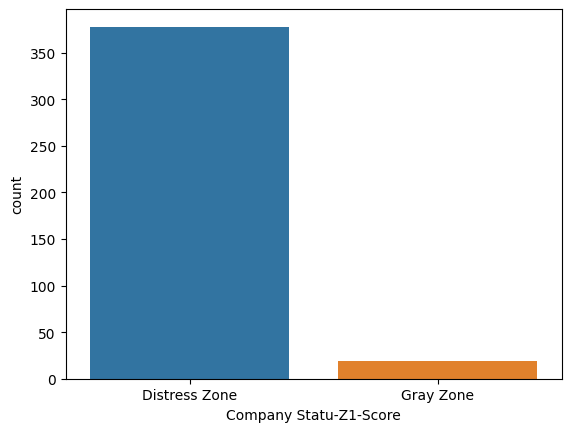

In [30]:
print(dframe['Company Statu-Z-Score'].value_counts())
sns.countplot(x=dframe['Company Statu-Z1-Score'])

In [31]:
filtered_df = dframe[dframe['Company Statu-Z-Score'] == 'Distress Zone']
grouped = filtered_df.groupby('Company Name')['Year'].agg(list).reset_index()
grouped.rename(columns={'Year': 'Years'}, inplace=True)
print(grouped)

   Company Name                                              Years
0           BAC  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
1         BACHF  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
2      BBAS3.SA  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
3           BCS  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
4        BNP.PA  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
5         BRK-B  [2012, 2011, 2010, 2009, 2008, 2003, 2002, 200...
6             C  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
7          FMCC  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
8          FNMA  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
9        GLE.PA  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
10           GS  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
11         HSBC  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
12          JPM  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
13          LYG  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 20

In [32]:
df_z1score = dframe.groupby('Company Statu-Z1-Score')['Z1-Score'].agg(
    [('Z1 Value Count', 'count'),
     ('Z1 Mean', 'mean'),
     ('Z1 Std', 'std'),
     ('Z1 Maximum', 'max'),
     ('Z1 Minimum', 'min')]
).reset_index()

df_z1score

,Company Statu-Z1-Score,Z1 Value Count,Z1 Mean,Z1 Std,Z1 Maximum,Z1 Minimum
0,Distress Zone,378,0.18,0.14,1.18,-0.36
1,Gray Zone,19,1.49,0.15,2.04,1.33


Company Statu-Z1-Score
Distress Zone    378
Gray Zone         19
Name: count, dtype: int64


<Axes: xlabel='Company Statu-Z1-Score', ylabel='count'>

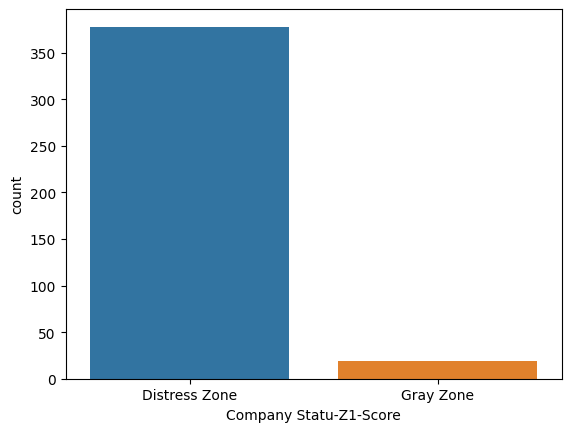

In [36]:
print(dframe['Company Statu-Z1-Score'].value_counts())
sns.countplot(x=dframe['Company Statu-Z1-Score'])

In [38]:
df_z2score = dframe.groupby('Company Statu-Z2-Score')['Z2-Score'].agg(
    [('Z2 Value Count', 'count'),
     ('Z2 Mean', 'mean'),
     ('Z2 Std', 'std'),
     ('Z2 Maximum', 'max'),
     ('Z2 Minimum', 'min')]
).reset_index()

df_z2score

,Company Statu-Z2-Score,Z2 Value Count,Z2 Mean,Z2 Std,Z2 Maximum,Z2 Minimum
0,Distress Zone,335,0.57,0.30,1.10,-1.04
1,Gray Zone,38,1.21,0.19,2.09,1.10
2,Safe Zone,24,5.10,0.76,7.03,3.37


Company Statu-Z2-Score
Distress Zone    335
Gray Zone         38
Safe Zone         24
Name: count, dtype: int64


<Axes: xlabel='Company Statu-Z2-Score', ylabel='count'>

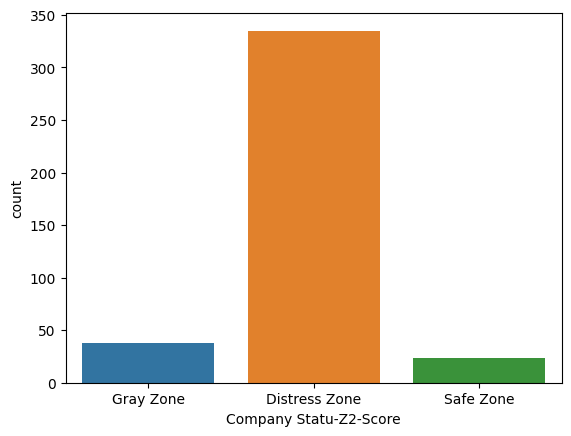

In [39]:
print(dframe['Company Statu-Z2-Score'].value_counts())
sns.countplot(x=dframe['Company Statu-Z2-Score'])

In [61]:
filtered_df = dframe[dframe['Company Statu-Z-Score'] == 'Distress Zone']
grouped = filtered_df.groupby('Company Name')['Year'].agg(list).reset_index()
grouped.rename(columns={'Year': 'Years'}, inplace=True)
result_list = grouped.to_dict(orient='records')
print(result_list)


[{'Company Name': 'BAC', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992]}, {'Company Name': 'BACHF', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008]}, {'Company Name': 'BBAS3.SA', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2010, 2009]}, {'Company Name': 'BCS', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991]}, {'Company Name': 'BNP.PA', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004]}, {'Company Name': 'BRK-B', 'Years': [2012, 2011, 2010, 2009, 2008, 2003, 2002, 2001, 2000, 1999, 1998]}, {'Company Name': 'C', 'Years': [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2

# T Test 5 Variable by the Z Score Model

In [41]:
import numpy as np
import pandas as pd
from scipy import stats

bankrupt_group = []
non_bankrupt_group = []
bankrupt_F_1 = []
non_bankrupt_F_1 = []
bankrupt_F_2 = []
non_bankrupt_F_2 = []
bankrupt_F_3 = []
non_bankrupt_F_3 = []
bankrupt_F_4 = []
non_bankrupt_F_4 = []
bankrupt_F_5 = []
non_bankrupt_F_5 = []

for i, row in dframe.iterrows():
    z_score = row['Z-Score']
    f_1 = row['F_1']
    f_2 = row['F_2']
    f_3 = row['F_3']
    f_4 = row['F_4']
    f_5 = row['F_5']
    
    if z_score >= 1.8:
        bankrupt_group.append(z_score)
        bankrupt_F_1.append(float(f_1))
        bankrupt_F_2.append(float(f_2))
        bankrupt_F_3.append(float(f_3))
        bankrupt_F_4.append(float(f_4))
        bankrupt_F_5.append(float(f_5))
    else:
        non_bankrupt_group.append(z_score)
        non_bankrupt_F_1.append(float(f_1))
        non_bankrupt_F_2.append(float(f_2))
        non_bankrupt_F_3.append(float(f_3))
        non_bankrupt_F_4.append(float(f_4))
        non_bankrupt_F_5.append(float(f_5))

# Calculate the mean for each group
mean_bankrupt = np.mean(bankrupt_group)
mean_non_bankrupt = np.mean(non_bankrupt_group)
mean_bankrupt_F_1 = np.mean(bankrupt_F_1)
mean_non_bankrupt_F_1 = np.mean(non_bankrupt_F_1)
mean_bankrupt_F_2 = np.mean(bankrupt_F_2)
mean_non_bankrupt_F_2 = np.mean(non_bankrupt_F_2)
mean_bankrupt_F_3 = np.mean(bankrupt_F_3)
mean_non_bankrupt_F_3 = np.mean(non_bankrupt_F_3)
mean_bankrupt_F_4 = np.mean(bankrupt_F_4)
mean_non_bankrupt_F_4 = np.mean(non_bankrupt_F_4)
mean_bankrupt_F_5 = np.mean(bankrupt_F_5)
mean_non_bankrupt_F_5 = np.mean(non_bankrupt_F_5)

# Calculate the standard deviation for each group
std_dev_bankrupt = np.std(bankrupt_group, ddof=1)
std_dev_non_bankrupt = np.std(non_bankrupt_group, ddof=1)  # ddof=1 for sample standard deviation
std_dev_bankrupt_F_1 = np.std(bankrupt_F_1, ddof=1)
std_dev_non_bankrupt_F_1 = np.std(non_bankrupt_F_1, ddof=1)
std_dev_bankrupt_F_2 = np.std(bankrupt_F_2, ddof=1)
std_dev_non_bankrupt_F_2 = np.std(non_bankrupt_F_2, ddof=1)
std_dev_bankrupt_F_3 = np.std(bankrupt_F_3, ddof=1)
std_dev_non_bankrupt_F_3 = np.std(non_bankrupt_F_3, ddof=1)
std_dev_bankrupt_F_4 = np.std(bankrupt_F_4, ddof=1)
std_dev_non_bankrupt_F_4 = np.std(non_bankrupt_F_4, ddof=1)
std_dev_bankrupt_F_5 = np.std(bankrupt_F_5, ddof=1)
std_dev_non_bankrupt_F_5 = np.std(non_bankrupt_F_5, ddof=1)

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(bankrupt_group, non_bankrupt_group)
t_statistic_F_1, p_value_F_1 = stats.ttest_ind(bankrupt_F_1,non_bankrupt_F_1)
t_statistic_F_2, p_value_F_2 = stats.ttest_ind(bankrupt_F_2,non_bankrupt_F_2)
t_statistic_F_3, p_value_F_3 = stats.ttest_ind(bankrupt_F_3,non_bankrupt_F_3)
t_statistic_F_4, p_value_F_4 = stats.ttest_ind(bankrupt_F_4,non_bankrupt_F_4)
t_statistic_F_5, p_value_F_5 = stats.ttest_ind(bankrupt_F_5,non_bankrupt_F_5)

results = {
    'Altman variables': ['Liquidity ratio(F_1)', 'Profitability ratio(F_2)', 'Efficiency ratio(F_3)','Market Value ratio(F_4)','Efficiency ratio(F_5)'],
    'Bankrupt' : [len(bankrupt_group),len(bankrupt_group),len(bankrupt_group),len(bankrupt_group),len(bankrupt_group)],
    'Mean-Bankrupt': [mean_bankrupt_F_1, mean_bankrupt_F_2, mean_bankrupt_F_3,mean_bankrupt_F_4,mean_bankrupt_F_5],
    'Standard Deviation-Bankrupt': [std_dev_bankrupt_F_1, std_dev_bankrupt_F_2, std_dev_bankrupt_F_3,std_dev_bankrupt_F_4,std_dev_bankrupt_F_5],
    
    'NonBankrupt' : [len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group)],
    'Mean-NonBankrupt': [mean_non_bankrupt_F_1, mean_non_bankrupt_F_2, mean_non_bankrupt_F_3,mean_non_bankrupt_F_4,mean_non_bankrupt_F_5],
    'Standard Deviation-NonBankrupt': [std_dev_non_bankrupt_F_1, std_dev_non_bankrupt_F_2, std_dev_non_bankrupt_F_3,std_dev_non_bankrupt_F_4,std_dev_non_bankrupt_F_5],
    
    
    'T-Statistic': [t_statistic_F_1, t_statistic_F_2,t_statistic_F_3,t_statistic_F_4,t_statistic_F_5],
    'P-Value': [p_value_F_1, p_value_F_2,p_value_F_3,p_value_F_4,p_value_F_5]
    
}

result_df_Zscore = pd.DataFrame(results)

alpha = 0.05
result_df_Zscore['Result'] = result_df_Zscore['P-Value'].apply(lambda p_value: "Reject the null hypothesis: There is a significant difference in Z-Scores." if p_value < alpha else "Fail to reject the null hypothesis: There is no significant difference in Z-Scores.")

result_df_Zscore

,Altman variables,Bankrupt,Mean-Bankrupt,Standard Deviation-Bankrupt,NonBankrupt,Mean-NonBankrupt,Standard Deviation-NonBankrupt,T-Statistic,P-Value,Result
0,Liquidity ratio(F_1),14,0.46,0.09,383,0.07,0.07,20.67,0.00,Reject the null hypothesis: There is a signifi...
1,Profitability ratio(F_2),14,0.29,0.10,383,0.04,0.04,20.81,0.00,Reject the null hypothesis: There is a signifi...
2,Efficiency ratio(F_3),14,0.06,0.03,383,0.01,0.01,15.50,0.00,Reject the null hypothesis: There is a signifi...
3,Market Value ratio(F_4),14,0.93,0.46,383,0.13,0.21,12.97,0.00,Reject the null hypothesis: There is a signifi...
4,Efficiency ratio(F_5),14,0.34,0.08,383,0.04,0.06,19.54,0.00,Reject the null hypothesis: There is a signifi...


# T Test 5 Variable by the Z1 Score Model

In [42]:
import numpy as np
import pandas as pd
from scipy import stats

bankrupt_group = []
non_bankrupt_group = []
bankrupt_F_1 = []
non_bankrupt_F_1 = []
bankrupt_F_2 = []
non_bankrupt_F_2 = []
bankrupt_F_3 = []
non_bankrupt_F_3 = []
bankrupt_F_6 = []
non_bankrupt_F_6 = []
bankrupt_F_5 = []
non_bankrupt_F_5 = []

for i, row in dframe.iterrows():
    z_score = row['Z1-Score']
    f_1 = row['F_1']
    f_2 = row['F_2']
    f_3 = row['F_3']
    f_6 = row['F_6']
    f_5 = row['F_5']
    
    if z_score >= 1.23:
        bankrupt_group.append(z_score)
        bankrupt_F_1.append(float(f_1))
        bankrupt_F_2.append(float(f_2))
        bankrupt_F_3.append(float(f_3))
        bankrupt_F_6.append(float(f_6))
        bankrupt_F_5.append(float(f_5))
    else:
        non_bankrupt_group.append(z_score)
        non_bankrupt_F_1.append(float(f_1))
        non_bankrupt_F_2.append(float(f_2))
        non_bankrupt_F_3.append(float(f_3))
        non_bankrupt_F_6.append(float(f_6))
        non_bankrupt_F_5.append(float(f_5))

# Calculate the mean for each group
mean_bankrupt = np.mean(bankrupt_group)
mean_non_bankrupt = np.mean(non_bankrupt_group)
mean_bankrupt_F_1 = np.mean(bankrupt_F_1)
mean_non_bankrupt_F_1 = np.mean(non_bankrupt_F_1)
mean_bankrupt_F_2 = np.mean(bankrupt_F_2)
mean_non_bankrupt_F_2 = np.mean(non_bankrupt_F_2)
mean_bankrupt_F_3 = np.mean(bankrupt_F_3)
mean_non_bankrupt_F_3 = np.mean(non_bankrupt_F_3)
mean_bankrupt_F_6 = np.mean(bankrupt_F_6)
mean_non_bankrupt_F_6 = np.mean(non_bankrupt_F_6)
mean_bankrupt_F_5 = np.mean(bankrupt_F_5)
mean_non_bankrupt_F_5 = np.mean(non_bankrupt_F_5)

# Calculate the standard deviation for each group
std_dev_bankrupt = np.std(bankrupt_group, ddof=1)
std_dev_non_bankrupt = np.std(non_bankrupt_group, ddof=1)  # ddof=1 for sample standard deviation
std_dev_bankrupt_F_1 = np.std(bankrupt_F_1, ddof=1)
std_dev_non_bankrupt_F_1 = np.std(non_bankrupt_F_1, ddof=1)
std_dev_bankrupt_F_2 = np.std(bankrupt_F_2, ddof=1)
std_dev_non_bankrupt_F_2 = np.std(non_bankrupt_F_2, ddof=1)
std_dev_bankrupt_F_3 = np.std(bankrupt_F_3, ddof=1)
std_dev_non_bankrupt_F_3 = np.std(non_bankrupt_F_3, ddof=1)
std_dev_bankrupt_F_6 = np.std(bankrupt_F_6, ddof=1)
std_dev_non_bankrupt_F_6 = np.std(non_bankrupt_F_6, ddof=1)
std_dev_bankrupt_F_5 = np.std(bankrupt_F_5, ddof=1)
std_dev_non_bankrupt_F_5 = np.std(non_bankrupt_F_5, ddof=1)

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(bankrupt_group, non_bankrupt_group)
t_statistic_F_1, p_value_F_1 = stats.ttest_ind(bankrupt_F_1,non_bankrupt_F_1)
t_statistic_F_2, p_value_F_2 = stats.ttest_ind(bankrupt_F_2,non_bankrupt_F_2)
t_statistic_F_3, p_value_F_3 = stats.ttest_ind(bankrupt_F_3,non_bankrupt_F_3)
t_statistic_F_6, p_value_F_6 = stats.ttest_ind(bankrupt_F_6,non_bankrupt_F_6)
t_statistic_F_5, p_value_F_5 = stats.ttest_ind(bankrupt_F_5,non_bankrupt_F_5)

results = {
    'Altman variables': ['Liquidity ratio(F_1)', 'Profitability ratio(F_2)', 'Efficiency ratio(F_3)','Net Worth ratio(F_6)','Efficiency ratio(F_5)'],
    'Bankrupt' : [len(bankrupt_group),len(bankrupt_group),len(bankrupt_group),len(bankrupt_group),len(bankrupt_group)],
    'Mean-Bankrupt': [mean_bankrupt_F_1, mean_bankrupt_F_2, mean_bankrupt_F_3,mean_bankrupt_F_6,mean_bankrupt_F_5],
    'Standard Deviation-Bankrupt': [std_dev_bankrupt_F_1, std_dev_bankrupt_F_2, std_dev_bankrupt_F_3,std_dev_bankrupt_F_6,std_dev_bankrupt_F_5],
    
    'NonBankrupt' : [len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group)],
    'Mean-NonBankrupt': [mean_non_bankrupt_F_1, mean_non_bankrupt_F_2, mean_non_bankrupt_F_3,mean_non_bankrupt_F_6,mean_non_bankrupt_F_5],
    'Standard Deviation-NonBankrupt': [std_dev_non_bankrupt_F_1, std_dev_non_bankrupt_F_2, std_dev_non_bankrupt_F_3,std_dev_non_bankrupt_F_6,std_dev_non_bankrupt_F_5],
    
    
    'T-Statistic': [t_statistic_F_1, t_statistic_F_2,t_statistic_F_3,t_statistic_F_6,t_statistic_F_5],
    'P-Value': [p_value_F_1, p_value_F_2,p_value_F_3,p_value_F_6,p_value_F_5]
    
}

result_df_Zscore1 = pd.DataFrame(results)

alpha = 0.05
result_df_Zscore1['Result'] = result_df_Zscore1['P-Value'].apply(lambda p_value: "Reject the null hypothesis: There is a significant difference in Z-Scores." if p_value < alpha else "Fail to reject the null hypothesis: There is no significant difference in Z-Scores.")

result_df_Zscore1

,Altman variables,Bankrupt,Mean-Bankrupt,Standard Deviation-Bankrupt,NonBankrupt,Mean-NonBankrupt,Standard Deviation-NonBankrupt,T-Statistic,P-Value,Result
0,Liquidity ratio(F_1),19,0.47,0.04,378,0.07,0.05,33.55,0.00,Reject the null hypothesis: There is a signifi...
1,Profitability ratio(F_2),19,0.29,0.08,378,0.03,0.03,32.99,0.00,Reject the null hypothesis: There is a signifi...
2,Efficiency ratio(F_3),19,0.06,0.02,378,0.01,0.01,17.50,0.00,Reject the null hypothesis: There is a signifi...
3,Net Worth ratio(F_6),19,0.89,0.16,378,0.07,0.09,37.99,0.00,Reject the null hypothesis: There is a signifi...
4,Efficiency ratio(F_5),19,0.36,0.06,378,0.04,0.04,35.36,0.00,Reject the null hypothesis: There is a signifi...


# T Test 5 Variable by the Z2 Score Model

In [43]:
import numpy as np
import pandas as pd
from scipy import stats

bankrupt_group = []
non_bankrupt_group = []
bankrupt_F_1 = []
non_bankrupt_F_1 = []
bankrupt_F_2 = []
non_bankrupt_F_2 = []
bankrupt_F_3 = []
non_bankrupt_F_3 = []
bankrupt_F_6 = []
non_bankrupt_F_6 = []
bankrupt_F_5 = []
non_bankrupt_F_5 = []

for i, row in dframe.iterrows():
    z_score = row['Z2-Score']
    f_1 = row['F_1']
    f_2 = row['F_2']
    f_3 = row['F_3']
    f_6 = row['F_6']
    
    if z_score >= 1.1:
        bankrupt_group.append(z_score)
        bankrupt_F_1.append(float(f_1))
        bankrupt_F_2.append(float(f_2))
        bankrupt_F_3.append(float(f_3))
        bankrupt_F_6.append(float(f_6))
    else:
        non_bankrupt_group.append(z_score)
        non_bankrupt_F_1.append(float(f_1))
        non_bankrupt_F_2.append(float(f_2))
        non_bankrupt_F_3.append(float(f_3))
        non_bankrupt_F_6.append(float(f_6))

# Calculate the mean for each group
mean_bankrupt = np.mean(bankrupt_group)
mean_non_bankrupt = np.mean(non_bankrupt_group)
mean_bankrupt_F_1 = np.mean(bankrupt_F_1)
mean_non_bankrupt_F_1 = np.mean(non_bankrupt_F_1)
mean_bankrupt_F_2 = np.mean(bankrupt_F_2)
mean_non_bankrupt_F_2 = np.mean(non_bankrupt_F_2)
mean_bankrupt_F_3 = np.mean(bankrupt_F_3)
mean_non_bankrupt_F_3 = np.mean(non_bankrupt_F_3)
mean_bankrupt_F_6 = np.mean(bankrupt_F_6)
mean_non_bankrupt_F_6 = np.mean(non_bankrupt_F_6)

# Calculate the standard deviation for each group
std_dev_bankrupt = np.std(bankrupt_group, ddof=1)
std_dev_non_bankrupt = np.std(non_bankrupt_group, ddof=1)  # ddof=1 for sample standard deviation
std_dev_bankrupt_F_1 = np.std(bankrupt_F_1, ddof=1)
std_dev_non_bankrupt_F_1 = np.std(non_bankrupt_F_1, ddof=1)
std_dev_bankrupt_F_2 = np.std(bankrupt_F_2, ddof=1)
std_dev_non_bankrupt_F_2 = np.std(non_bankrupt_F_2, ddof=1)
std_dev_bankrupt_F_3 = np.std(bankrupt_F_3, ddof=1)
std_dev_non_bankrupt_F_3 = np.std(non_bankrupt_F_3, ddof=1)
std_dev_bankrupt_F_6 = np.std(bankrupt_F_6, ddof=1)
std_dev_non_bankrupt_F_6 = np.std(non_bankrupt_F_6, ddof=1)

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(bankrupt_group, non_bankrupt_group)
t_statistic_F_1, p_value_F_1 = stats.ttest_ind(bankrupt_F_1,non_bankrupt_F_1)
t_statistic_F_2, p_value_F_2 = stats.ttest_ind(bankrupt_F_2,non_bankrupt_F_2)
t_statistic_F_3, p_value_F_3 = stats.ttest_ind(bankrupt_F_3,non_bankrupt_F_3)
t_statistic_F_6, p_value_F_6 = stats.ttest_ind(bankrupt_F_6,non_bankrupt_F_6)

results = {
    'Altman variables': ['Liquidity ratio(F_1)', 'Profitability ratio(F_2)', 'Efficiency ratio(F_3)','Net Worth ratio(F_6)'],
    'Bankrupt' : [len(bankrupt_group),len(bankrupt_group),len(bankrupt_group),len(bankrupt_group)],
    'Mean-Bankrupt': [mean_bankrupt_F_1, mean_bankrupt_F_2, mean_bankrupt_F_3,mean_bankrupt_F_6],
    'Standard Deviation-Bankrupt': [std_dev_bankrupt_F_1, std_dev_bankrupt_F_2, std_dev_bankrupt_F_3,std_dev_bankrupt_F_6],
    
    'NonBankrupt' : [len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group),len(non_bankrupt_group)],
    'Mean-NonBankrupt': [mean_non_bankrupt_F_1, mean_non_bankrupt_F_2, mean_non_bankrupt_F_3,mean_non_bankrupt_F_6],
    'Standard Deviation-NonBankrupt': [std_dev_non_bankrupt_F_1, std_dev_non_bankrupt_F_2, std_dev_non_bankrupt_F_3,std_dev_non_bankrupt_F_6],
    
    
    'T-Statistic': [t_statistic_F_1, t_statistic_F_2,t_statistic_F_3,t_statistic_F_6],
    'P-Value': [p_value_F_1, p_value_F_2,p_value_F_3,p_value_F_6]
    
}

result_df_Zscore2 = pd.DataFrame(results)

alpha = 0.05
result_df_Zscore2['Result'] = result_df_Zscore2['P-Value'].apply(lambda p_value: "Reject the null hypothesis: There is a significant difference in Z-Scores." if p_value < alpha else "Fail to reject the null hypothesis: There is no significant difference in Z-Scores.")

result_df_Zscore2

,Altman variables,Bankrupt,Mean-Bankrupt,Standard Deviation-Bankrupt,NonBankrupt,Mean-NonBankrupt,Standard Deviation-NonBankrupt,T-Statistic,P-Value,Result
0,Liquidity ratio(F_1),62,0.25,0.17,335,0.06,0.03,19.24,0.00,Reject the null hypothesis: There is a signifi...
1,Profitability ratio(F_2),62,0.14,0.11,335,0.03,0.02,17.06,0.00,Reject the null hypothesis: There is a signifi...
2,Efficiency ratio(F_3),62,0.03,0.02,335,0.01,0.01,11.90,0.00,Reject the null hypothesis: There is a signifi...
3,Net Worth ratio(F_6),62,0.41,0.37,335,0.06,0.03,17.07,0.00,Reject the null hypothesis: There is a signifi...


# K-Means clustering for the Modified Altman Z-Score 

In [44]:
from sklearn.cluster import KMeans

X=dframe['Z-Score'].values.reshape(-1, 1)

k = 3

kmeans = KMeans(n_clusters=k, random_state=0)
dframe['K-means clustering(Z-Score)'] = kmeans.fit_predict(X)

cluster_centroids = kmeans.cluster_centers_

sorted_centroids = np.sort(cluster_centroids.flatten())

cut_points = {
    'Distress': sorted_centroids[0],
    'Gray': sorted_centroids[1],
    'Safe': sorted_centroids[2]
}

def classify_financial_health(z_score):
    if z_score <= cut_points['Distress']:
        return 'Distress'
    elif cut_points['Distress'] < z_score <= cut_points['Gray']:
        return 'Gray'
    else:
        return 'Safe'

dframe['Company Statu-K-Mean(Z-Score)'] = dframe['Z-Score'].apply(classify_financial_health)

print(dframe[['Company Name', 'Z-Score', 'K-means clustering(Z-Score)', 'Company Statu-K-Mean(Z-Score)']])

    Company Name  Z-Score  K-means clustering(Z-Score)   
0            BAC     0.37                            2  \
1            BAC     0.35                            2   
2            BAC     0.35                            2   
3            BAC     0.33                            2   
4            BAC     0.31                            0   
..           ...      ...                          ...   
602          WFC     0.42                            2   
603          WFC     0.40                            2   
604          WFC     0.36                            2   
605          WFC     0.31                            0   
606          WFC     0.34                            2   

    Company Statu-K-Mean(Z-Score)  
0                            Gray  
1                            Gray  
2                            Gray  
3                            Gray  
4                            Gray  
..                            ...  
602                          Gray  
603            

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
df_kmeanzscore = dframe.groupby('Company Statu-K-Mean(Z-Score)')['Z-Score'].agg(
    [('Count', 'count'),
     ('Mean', 'mean'),
     ('Std', 'std'),
     ('Maximum', 'max'),
     ('Minimum', 'min')]
).reset_index()

df_kmeanzscore

,Company Statu-K-Mean(Z-Score),Count,Mean,Std,Maximum,Minimum
0,Distress,123,0.10,0.10,0.18,-0.44
1,Gray,215,0.27,0.08,0.46,0.18
2,Safe,59,1.18,0.65,2.59,0.47


Company Statu-K-Mean(Z-Score)
Gray        215
Distress    123
Safe         59
Name: count, dtype: int64


<Axes: xlabel='Company Statu-K-Mean(Z-Score)', ylabel='count'>

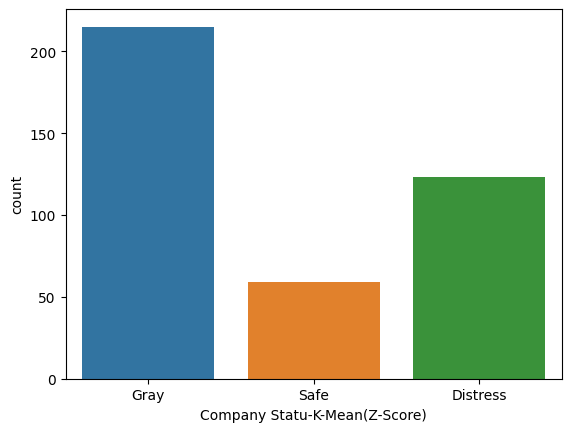

In [46]:
print(dframe['Company Statu-K-Mean(Z-Score)'].value_counts())
sns.countplot(x=dframe['Company Statu-K-Mean(Z-Score)'])

# K-Means clustering for the Modified Altman Z1-Score 

In [47]:
from sklearn.cluster import KMeans

X=dframe['Z1-Score'].values.reshape(-1, 1)

k = 3

kmeans = KMeans(n_clusters=k, random_state=0)
dframe['K-means clustering(Z1-Score)'] = kmeans.fit_predict(X)

cluster_centroids = kmeans.cluster_centers_

sorted_centroids = np.sort(cluster_centroids.flatten())

cut_points = {
    'Distress': sorted_centroids[0],
    'Gray': sorted_centroids[1],
    'Safe': sorted_centroids[2]
}

def classify_financial_health(z_score):
    if z_score <= cut_points['Distress']:
        return 'Distress'
    elif cut_points['Distress'] < z_score <= cut_points['Gray']:
        return 'Gray'
    else:
        return 'Safe'

dframe['Company Statu-K-Mean(Z1-Score)'] = dframe['Z1-Score'].apply(classify_financial_health)

print(dframe[['Company Name', 'Z1-Score', 'K-means clustering(Z1-Score)', 'Company Statu-K-Mean(Z1-Score)']])

    Company Name  Z1-Score  K-means clustering(Z1-Score)   
0            BAC      0.26                             0  \
1            BAC      0.27                             0   
2            BAC      0.26                             0   
3            BAC      0.26                             0   
4            BAC      0.25                             0   
..           ...       ...                           ...   
602          WFC      0.26                             0   
603          WFC      0.24                             0   
604          WFC      0.22                             0   
605          WFC      0.20                             0   
606          WFC      0.20                             0   

    Company Statu-K-Mean(Z1-Score)  
0                             Safe  
1                             Safe  
2                             Safe  
3                             Safe  
4                             Safe  
..                             ...  
602                 

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
df_kmeanz1score = dframe.groupby('Company Statu-K-Mean(Z1-Score)')['Z1-Score'].agg(
    [('Count', 'count'),
     ('Mean', 'mean'),
     ('Std', 'std'),
     ('Maximum', 'max'),
     ('Minimum', 'min')]
).reset_index()

df_kmeanz1score

,Company Statu-K-Mean(Z1-Score),Count,Mean,Std,Maximum,Minimum
0,Distress,70,0.04,0.08,0.10,-0.36
1,Gray,232,0.16,0.04,0.24,0.10
2,Safe,95,0.57,0.50,2.04,0.25


Company Statu-K-Mean(Z1-Score)
Gray        232
Safe         95
Distress     70
Name: count, dtype: int64


<Axes: xlabel='Company Statu-K-Mean(Z1-Score)', ylabel='count'>

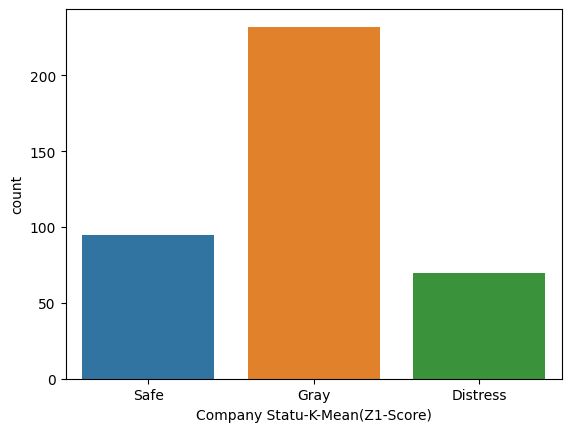

In [49]:
print(dframe['Company Statu-K-Mean(Z1-Score)'].value_counts())
sns.countplot(x=dframe['Company Statu-K-Mean(Z1-Score)'])

# K-Means clustering for the Modified Altman Z2-Score 

In [50]:
from sklearn.cluster import KMeans

X=dframe['Z2-Score'].values.reshape(-1, 1)

k = 3

kmeans = KMeans(n_clusters=k, random_state=0)
dframe['K-means clustering(Z2-Score)'] = kmeans.fit_predict(X)

cluster_centroids = kmeans.cluster_centers_

sorted_centroids = np.sort(cluster_centroids.flatten())

cut_points = {
    'Distress': sorted_centroids[0],
    'Gray': sorted_centroids[1],
    'Safe': sorted_centroids[2]
}

def classify_financial_health(z_score):
    if z_score <= cut_points['Distress']:
        return 'Distress'
    elif cut_points['Distress'] < z_score <= cut_points['Gray']:
        return 'Gray'
    else:
        return 'Safe'

dframe['Company Statu-K-Mean(Z2-Score)'] = dframe['Z2-Score'].apply(classify_financial_health)

print(dframe[['Company Name', 'Z2-Score', 'K-means clustering(Z2-Score)', 'Company Statu-K-Mean(Z2-Score)']])

    Company Name Z2-Score  K-means clustering(Z2-Score)   
0            BAC     1.14                             2  \
1            BAC     1.16                             2   
2            BAC     1.16                             2   
3            BAC     1.18                             2   
4            BAC     1.13                             2   
..           ...      ...                           ...   
602          WFC     0.82                             2   
603          WFC     0.78                             2   
604          WFC     0.73                             2   
605          WFC     0.63                             0   
606          WFC     0.64                             0   

    Company Statu-K-Mean(Z2-Score)  
0                             Safe  
1                             Safe  
2                             Safe  
3                             Safe  
4                             Safe  
..                             ...  
602                           Gr

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
df_kmeanz2score = dframe.groupby('Company Statu-K-Mean(Z2-Score)')['Z2-Score'].agg(
    [('Count', 'count'),
     ('Mean', 'mean'),
     ('Std', 'std'),
     ('Maximum', 'max'),
     ('Minimum', 'min')]
).reset_index()

df_kmeanz2score

,Company Statu-K-Mean(Z2-Score),Count,Mean,Std,Maximum,Minimum
0,Distress,77,0.18,0.28,0.40,-1.04
1,Gray,228,0.64,0.15,0.94,0.41
2,Safe,92,2.16,1.80,7.03,0.94


Company Statu-K-Mean(Z2-Score)
Gray        228
Safe         92
Distress     77
Name: count, dtype: int64


<Axes: xlabel='Company Statu-K-Mean(Z2-Score)', ylabel='count'>

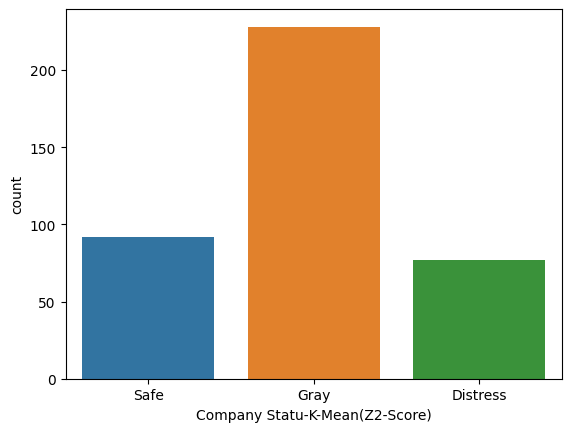

In [52]:
print(dframe['Company Statu-K-Mean(Z2-Score)'].value_counts())
sns.countplot(x=dframe['Company Statu-K-Mean(Z2-Score)'])

In [53]:
#'ABT', 'GSK', 'MRK', 'NVO?', 'PFE', 'PRGO', 'RDY' 
dframe[['Company Name','Year','Z2-Score','Company Statu-Z-Score','Company Statu-K-Mean(Z-Score)','Company Statu-Z1-Score','Company Statu-K-Mean(Z1-Score)','Company Statu-Z2-Score','Company Statu-K-Mean(Z2-Score)']][dframe['Company Statu-K-Mean(Z2-Score)']=='Distress']

,Company Name,Year,Z2-Score,Company Statu-Z-Score,Company Statu-K-Mean(Z-Score),Company Statu-Z1-Score,Company Statu-K-Mean(Z1-Score),Company Statu-Z2-Score,Company Statu-K-Mean(Z2-Score)
115,BCS,2012,0.40,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
119,BCS,2008,0.23,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
120,BCS,2007,0.28,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
121,BCS,2006,0.29,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
122,BCS,2005,0.26,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
...,...,...,...,...,...,...,...,...,...
554,UBS,2005,0.30,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
555,UBS,2004,0.28,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
556,UBS,2003,0.34,Distress Zone,Distress,Distress Zone,Distress,Distress Zone,Distress
557,UBS,2002,0.39,Distress Zone,Distress,Distress Zone,Gray,Distress Zone,Distress


In [54]:
filtered_df = dframe[dframe['Company Statu-K-Mean(Z2-Score)'] == 'Distress']
grouped = filtered_df.groupby('Company Name')['Year'].agg(list).reset_index()
grouped.rename(columns={'Year': 'Years'}, inplace=True)
print(grouped)

  Company Name                                              Years
0          BCS  [2012, 2008, 2007, 2006, 2005, 2004, 2002, 199...
1       BNP.PA               [2009, 2008, 2007, 2006, 2005, 2004]
2         FMCC  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
3         FNMA  [2019, 2018, 2017, 2016, 2015, 2014, 2013, 201...
4       GLE.PA                     [2012, 2008, 2007, 2006, 2005]
5           GS                                             [1999]
6          JPM                                             [1989]
7          LYG               [2013, 2012, 2011, 2010, 2009, 2008]
8          UBS  [2012, 2011, 2010, 2009, 2008, 2007, 2006, 200...


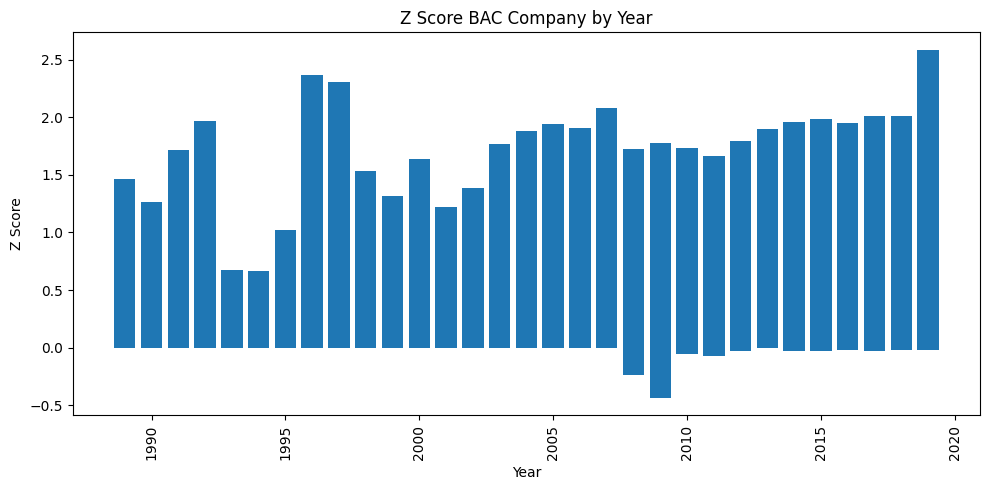

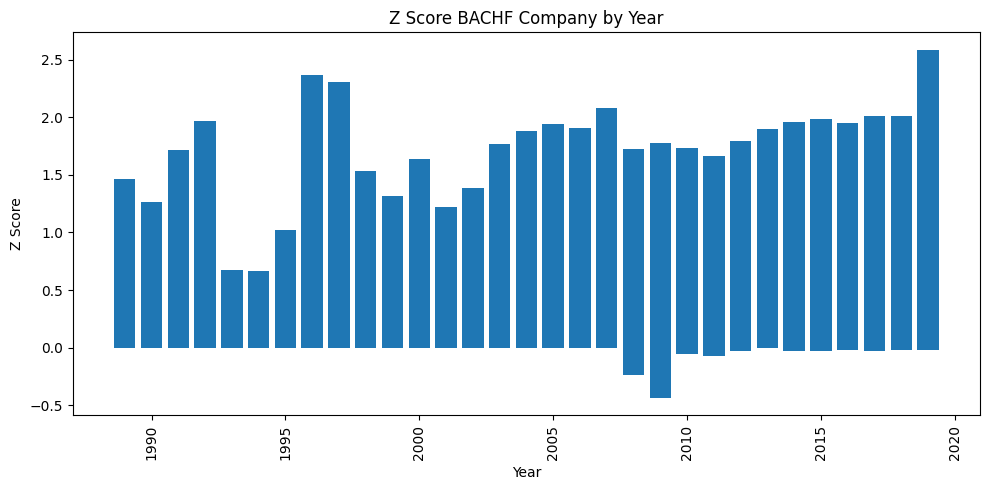

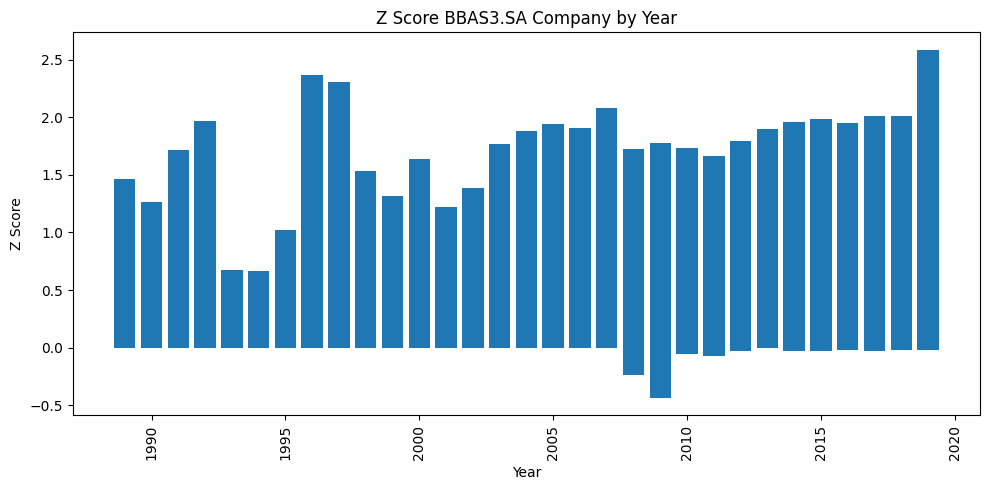

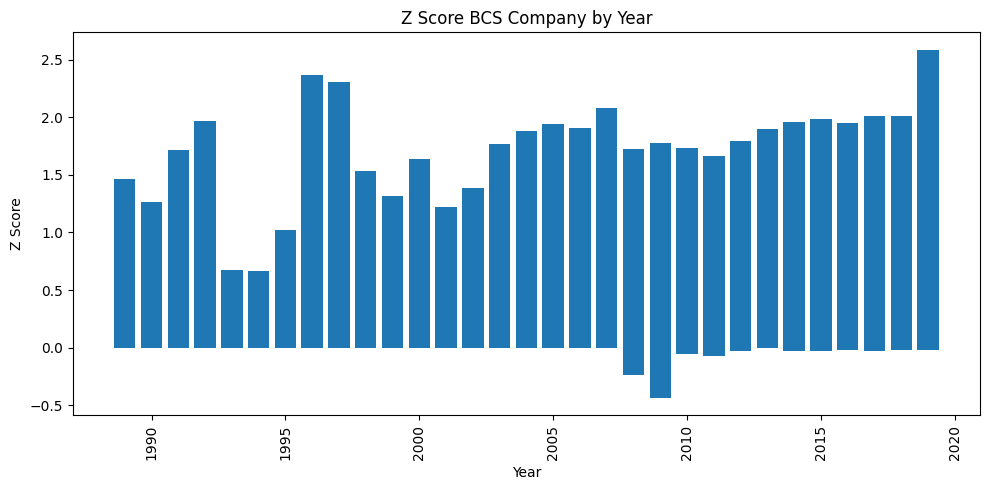

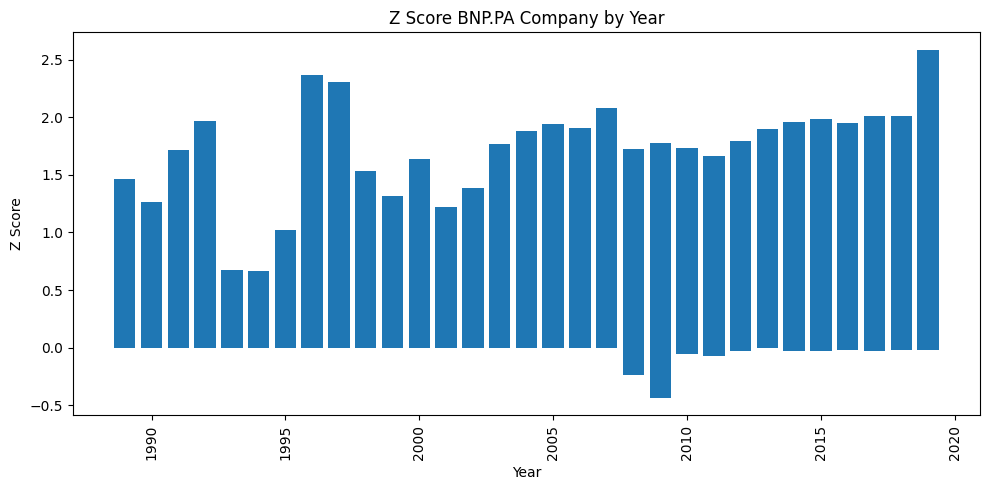

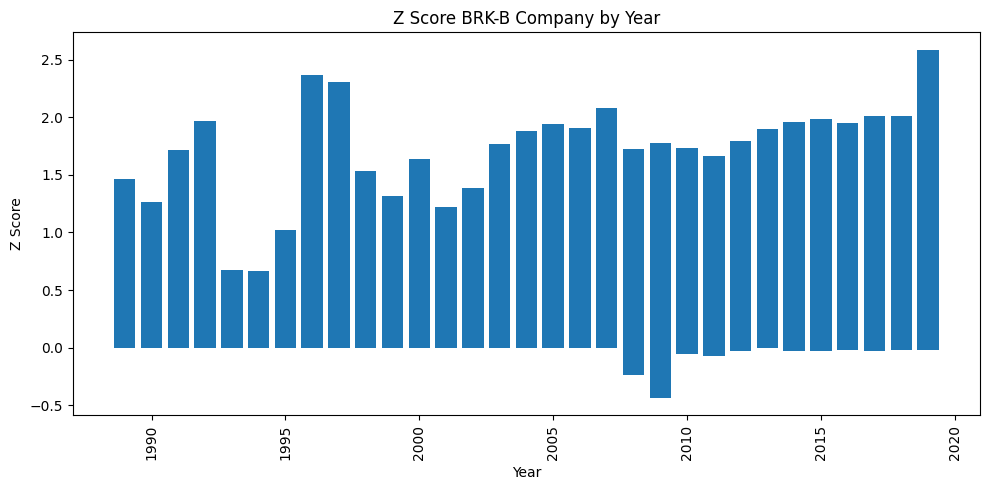

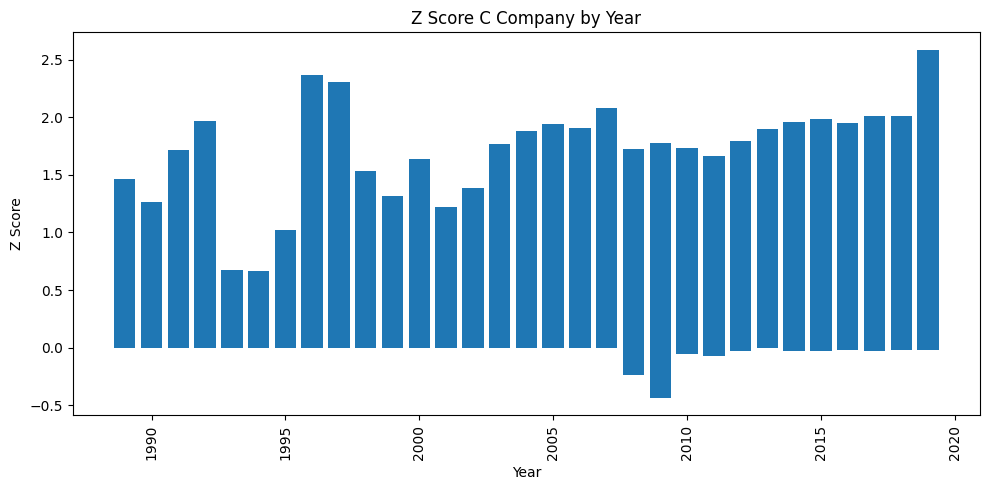

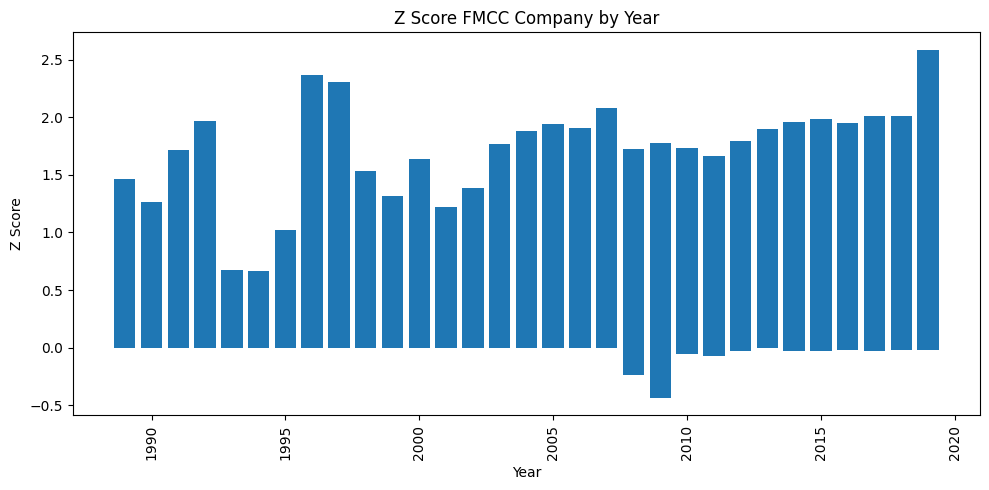

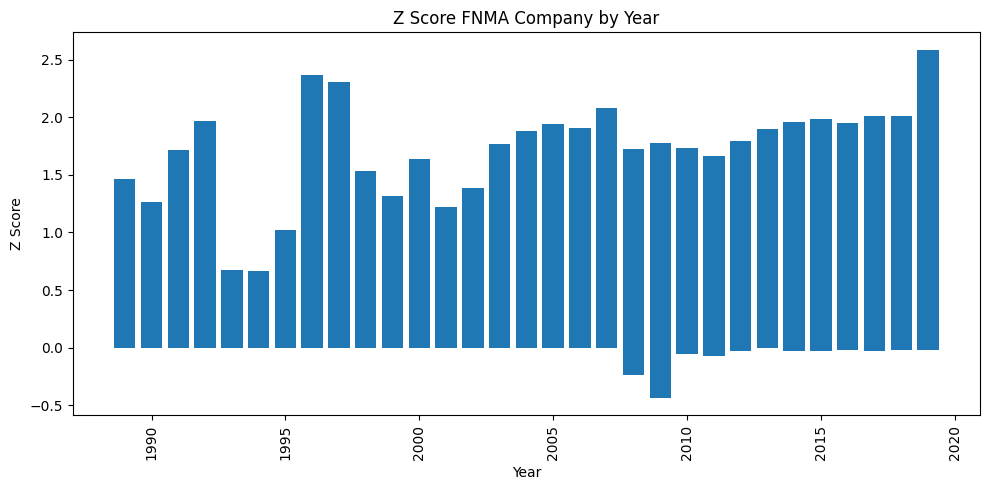

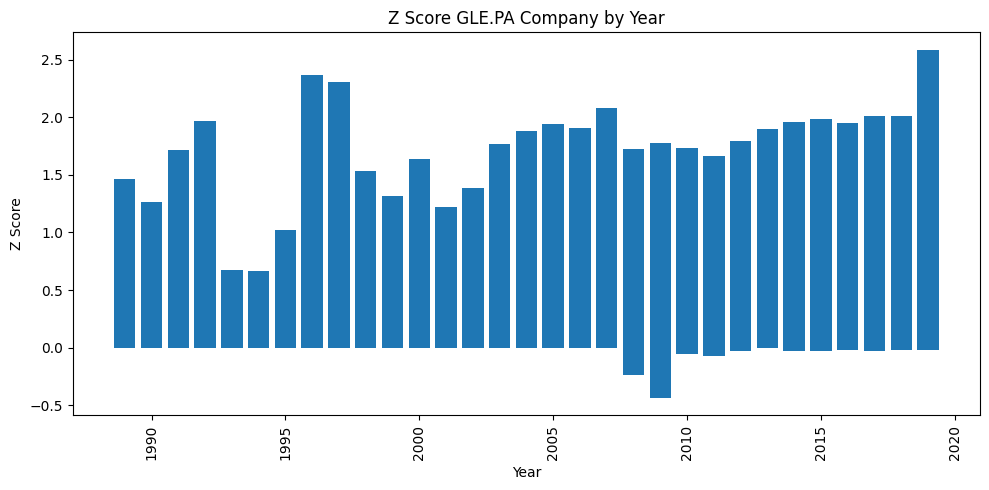

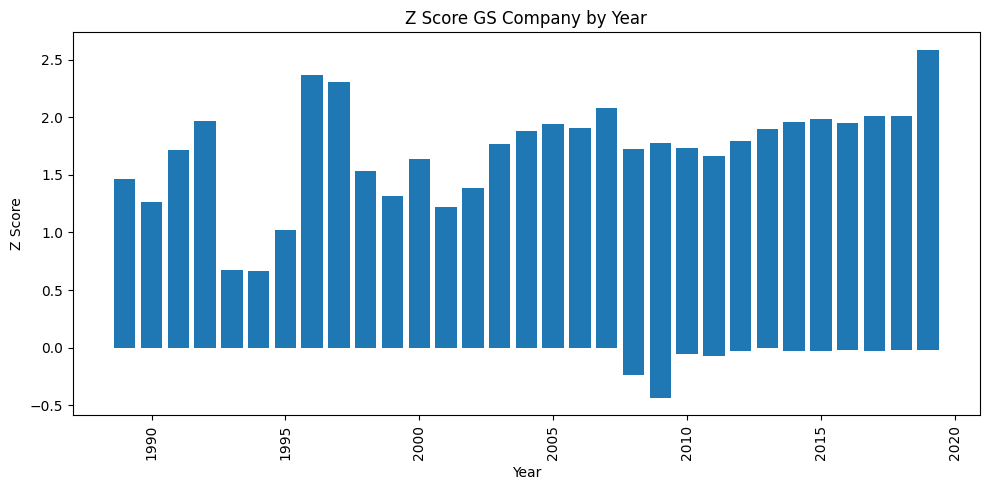

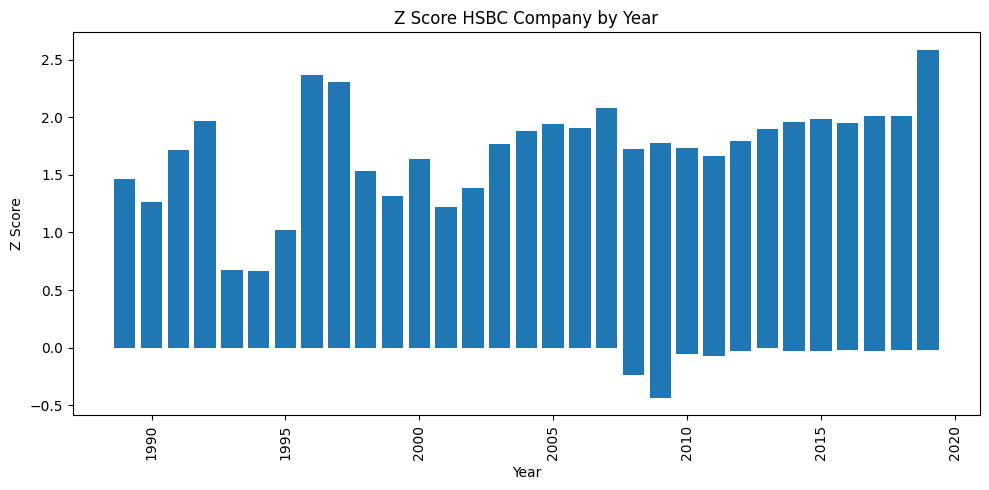

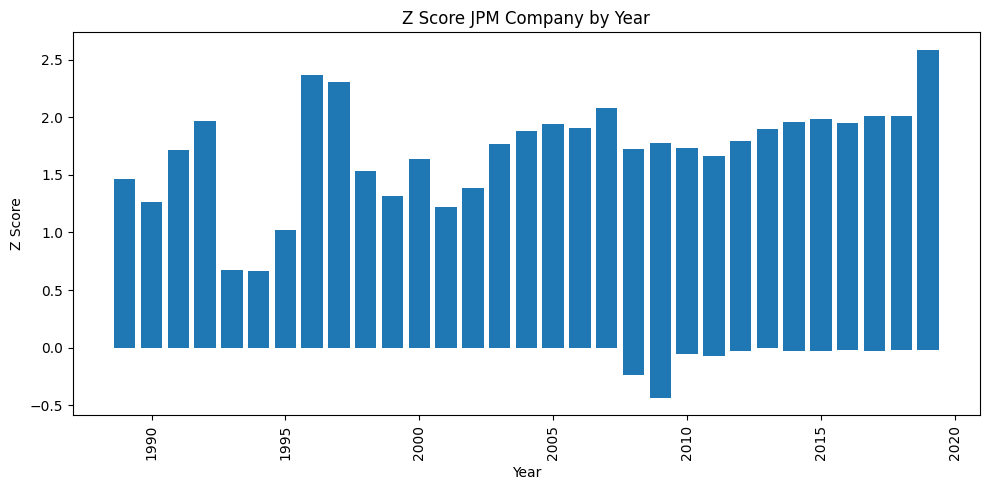

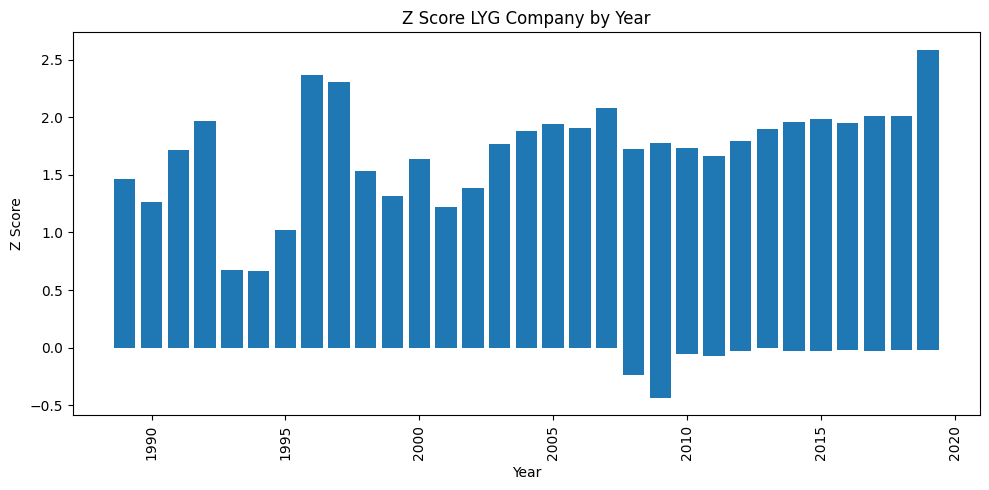

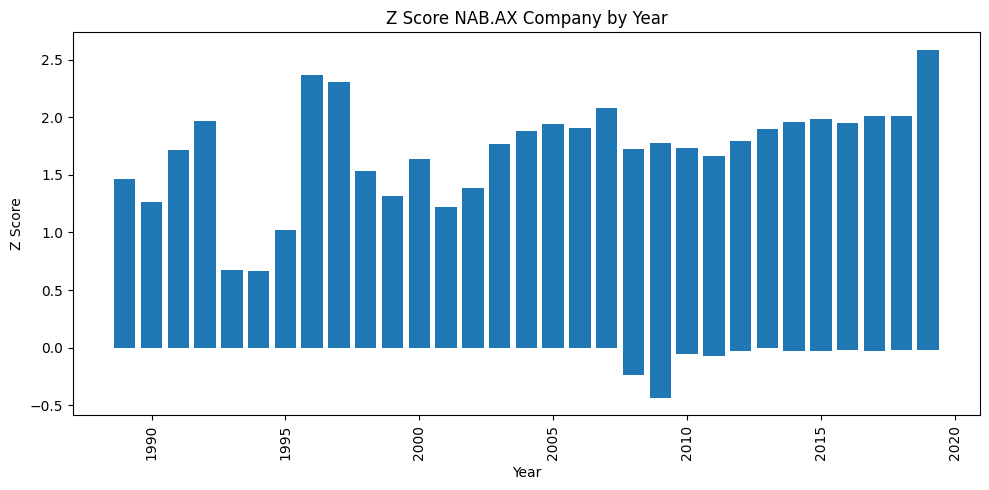

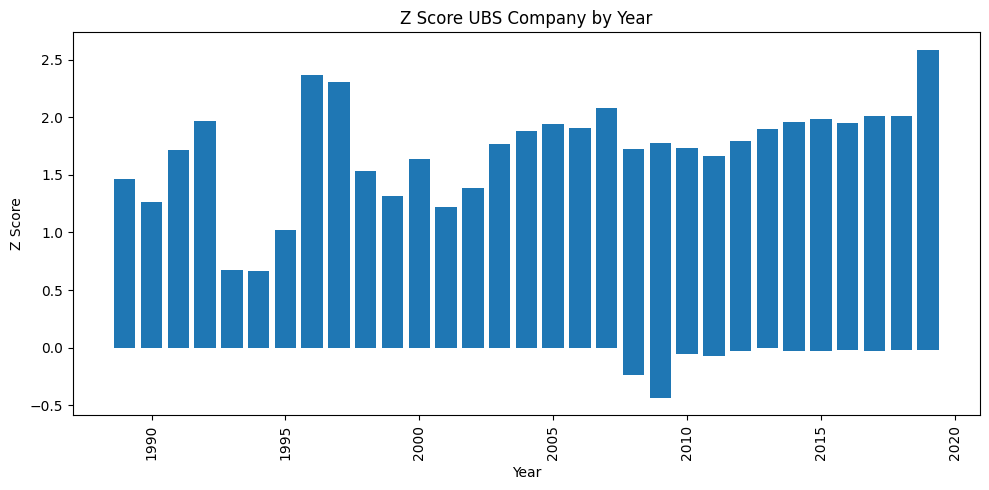

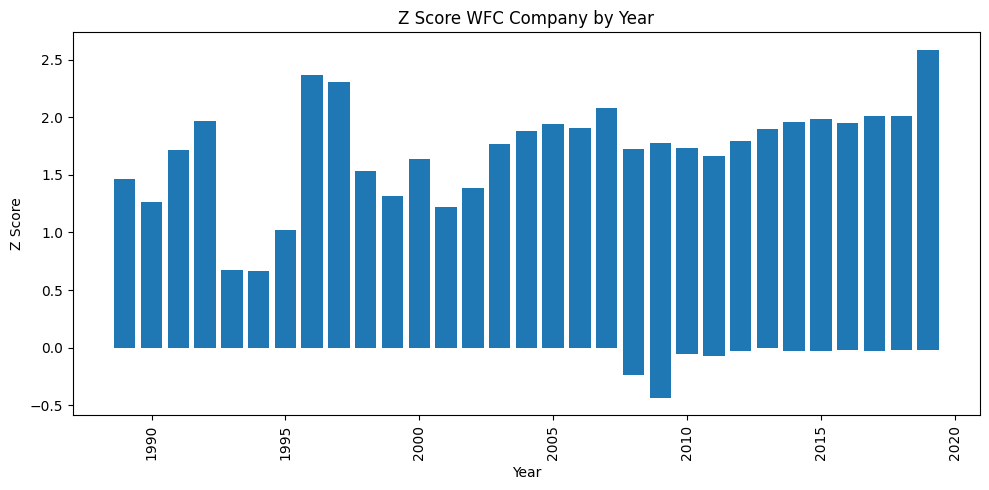

WFC not found in the DataFrame.


In [55]:
import matplotlib.pyplot as plt

for company in companies:
    Year=dframe['Year']
    Zscore=dframe['Z-Score']
    
    plt.figure(figsize=(10, 5))
    plt.bar(Year, Zscore)  
    plt.xlabel('Year')
    plt.ylabel('Z Score')
    plt.title(f'Z Score {company} Company by Year')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
       
else:
    print(f"{company} not found in the DataFrame.")